In [1]:
# Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns #used for data visualization
import warnings 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve
warnings.filterwarnings('ignore') # to ignore deprecated functions


# A. Data Wrangling & Feature Engineering

In [2]:
# Load data using read_csv()
data = pd.read_csv('MedicalCentre.csv')
# the shape of a Dataframe
data.shape

(110527, 14)

In [3]:
# Show initial 5 records
data.head()

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show
0,2.990000e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62.0,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.590000e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56.0,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.260000e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62.0,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.680000e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8.0,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.840000e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56.0,JARDIM DA PENHA,0,1,1,0,0,0,No


## 1. Prepare the data for downstream processes, e.g., deal with missing values, duplicates 	

### Missing values

In [4]:
# check for missing values
print("Missing values:\n", data.isnull().sum())

Missing values:
 PatientID         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               3
Neighbourhood     0
Scholarship       0
Hypertension      0
Diabetes          0
Alcoholism        0
Handicap          0
SMS_received      0
No-show           0
dtype: int64


There are 3 missing value in the age columns.

In [5]:
# Drop missing value rows using dropna() function
data = data.dropna()
data.shape

(110524, 14)

We can see that there is 110524 rows now, we drop 3 null values which is in the age columns.

### Duplicates 	

In [6]:
# drop duplicates
print("Duplicates:\n", data.duplicated().sum())
data = data.drop_duplicates()
data.shape

Duplicates:
 0


(110524, 14)

No duplicate data in our dataset，and we don't need patientID and AppointmentID in the later analysis, so we drop them from the dataset in advance。

In [7]:
#drop the patientID and AppointmentID
data = data.drop(['PatientID','AppointmentID'],axis=1,inplace=False)
data.shape

(110524, 12)

## 2. Determine the frequency of distinct values in each feature set

In [8]:
# Check the descriptive statistics
data.describe()

,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received
count,110524.000000,110524.000000,110524.000000,110524.000000,110524.000000,110524.000000,110524.000000
mean,37.088488,0.098268,0.197251,0.071867,0.030401,0.022249,0.321025
std,23.110271,0.297678,0.397925,0.258268,0.171688,0.161545,0.466873
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [9]:
# check the frequency of distinct values in each feature set
for column in data.columns:
    print(column)
    print(data[column].value_counts())
    print()

Gender
F    71838
M    38686
Name: Gender, dtype: int64

ScheduledDay
2016-05-06T07:09:54Z    24
2016-05-06T07:09:53Z    23
2016-04-25T17:17:46Z    22
2016-04-25T17:18:27Z    22
2016-04-25T17:17:23Z    19
                        ..
2016-05-16T09:12:51Z     1
2016-05-09T10:48:50Z     1
2016-05-02T09:53:25Z     1
2016-05-30T09:12:28Z     1
2016-04-27T13:30:56Z     1
Name: ScheduledDay, Length: 103546, dtype: int64

AppointmentDay
2016-06-06T00:00:00Z    4692
2016-05-16T00:00:00Z    4613
2016-05-09T00:00:00Z    4520
2016-05-30T00:00:00Z    4514
2016-06-08T00:00:00Z    4479
2016-05-11T00:00:00Z    4474
2016-06-01T00:00:00Z    4464
2016-06-07T00:00:00Z    4416
2016-05-12T00:00:00Z    4394
2016-05-02T00:00:00Z    4376
2016-05-18T00:00:00Z    4373
2016-05-17T00:00:00Z    4372
2016-06-02T00:00:00Z    4310
2016-05-10T00:00:00Z    4308
2016-05-31T00:00:00Z    4279
2016-05-05T00:00:00Z    4273
2016-05-19T00:00:00Z    4270
2016-05-03T00:00:00Z    4256
2016-05-04T00:00:00Z    4168
2016-06-03T00:00:

In [10]:
# show frequency of distinct values in each colunm
for col in data.columns:
    print(col, data[col].nunique())

Gender 2
ScheduledDay 103546
AppointmentDay 27
Age 104
Neighbourhood 81
Scholarship 2
Hypertension 2
Diabetes 2
Alcoholism 2
Handicap 5
SMS_received 2
No-show 2


## 3. Initialize a function to plot relevant features within the dataset to visualize for outliers

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110524 entries, 0 to 110526
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Gender          110524 non-null  object 
 1   ScheduledDay    110524 non-null  object 
 2   AppointmentDay  110524 non-null  object 
 3   Age             110524 non-null  float64
 4   Neighbourhood   110524 non-null  object 
 5   Scholarship     110524 non-null  int64  
 6   Hypertension    110524 non-null  int64  
 7   Diabetes        110524 non-null  int64  
 8   Alcoholism      110524 non-null  int64  
 9   Handicap        110524 non-null  int64  
 10  SMS_received    110524 non-null  int64  
 11  No-show         110524 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 11.0+ MB


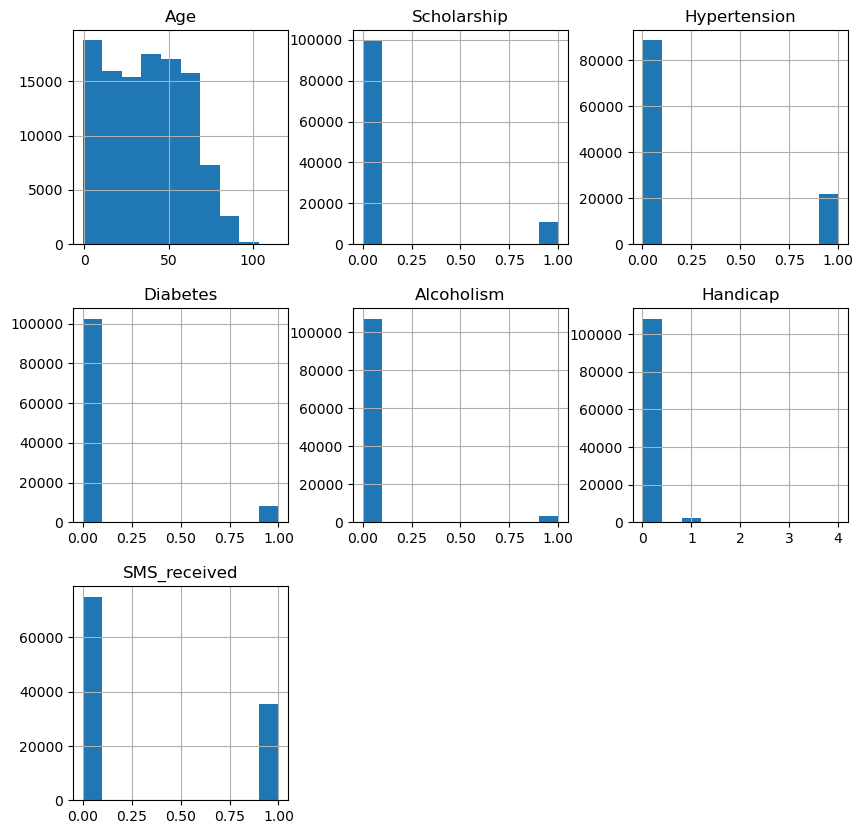

In [12]:
# histogram for each feature
data.hist(bins=10,figsize=(10,10))
plt.show() 

Outliers can only be checked for numerical values, so we see the data type where age is numerical type. From 5 scholarship to 10 SMS_received, except for 9 Handicap, these data types are all int64, but in question 2, we see that their distribution is only 2, which means they are binary, so none of them have outliers. For 9 Handicap, it has too few other values, so it won't have outliers either. 

We only need to focus on the outliers of age.

<AxesSubplot: xlabel='Age'>

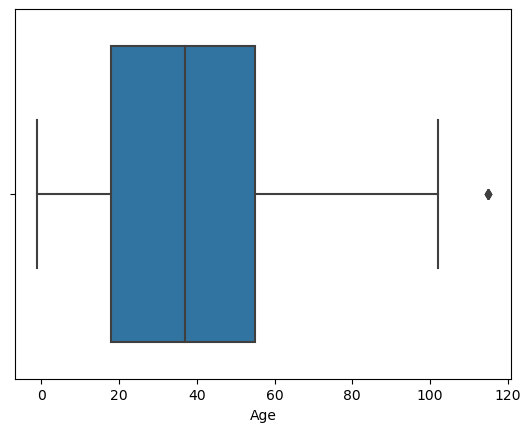

In [13]:
sns.boxplot(x='Age',data=data)
plt.subplot()

From the graph, we see that there is one outlier in the age column.

## 4.  Count the frequency of negative Age feature observations, and remove them

In [14]:
# count the frequency of nagative age feature observation
print("Negative Age values:", (data["Age"] < 0).sum())
# Filter age who under zero and show it. 
data[(data.Age <0)]

Negative Age values: 1


,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show
99832,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1.0,ROMÃO,0,0,0,0,0,0,No


In [15]:
# remove negative age 
data = data[data["Age"] >= 0]

## 5. The values within AwaitingTime are negative, transform them into positive values

In [16]:
# Convert the ScheduledDay and AppointmentDay columns to datetime
data['ScheduledDay'] = pd.to_datetime(data['ScheduledDay'])
data['AppointmentDay'] = pd.to_datetime(data['AppointmentDay'])

# Calculate the waiting time and convert it to days
data['AwaitingTime'] = (data['ScheduledDay'] - data['AppointmentDay']).dt.days

# transform them into positive values
data["AwaitingTime"] = abs(data["AwaitingTime"])

data.head()

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,AwaitingTime
0,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62.0,JARDIM DA PENHA,0,1,0,0,0,0,No,0
1,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56.0,JARDIM DA PENHA,0,0,0,0,0,0,No,0
2,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62.0,MATA DA PRAIA,0,0,0,0,0,0,No,0
3,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8.0,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0
4,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56.0,JARDIM DA PENHA,0,1,1,0,0,0,No,0


## 6. ML algorithm requires the variables to be coded into its equivalent integer codes. Encode the string categorical values into an integer code

In [17]:
# check the information of dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110523 entries, 0 to 110526
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   Gender          110523 non-null  object             
 1   ScheduledDay    110523 non-null  datetime64[ns, UTC]
 2   AppointmentDay  110523 non-null  datetime64[ns, UTC]
 3   Age             110523 non-null  float64            
 4   Neighbourhood   110523 non-null  object             
 5   Scholarship     110523 non-null  int64              
 6   Hypertension    110523 non-null  int64              
 7   Diabetes        110523 non-null  int64              
 8   Alcoholism      110523 non-null  int64              
 9   Handicap        110523 non-null  int64              
 10  SMS_received    110523 non-null  int64              
 11  No-show         110523 non-null  object             
 12  AwaitingTime    110523 non-null  int64              
dtypes: datetime64[

In [18]:
# Define the columns to encode
cols_to_encode = ['Gender', 'Age', 'Neighbourhood', 'No-show']

# Initialize the LabelEncoder
le = LabelEncoder()

# Encode the categorical columns
for col in cols_to_encode:
    data[col] = le.fit_transform(data[col])

# check all data type into an integer code
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110523 entries, 0 to 110526
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   Gender          110523 non-null  int64              
 1   ScheduledDay    110523 non-null  datetime64[ns, UTC]
 2   AppointmentDay  110523 non-null  datetime64[ns, UTC]
 3   Age             110523 non-null  int64              
 4   Neighbourhood   110523 non-null  int64              
 5   Scholarship     110523 non-null  int64              
 6   Hypertension    110523 non-null  int64              
 7   Diabetes        110523 non-null  int64              
 8   Alcoholism      110523 non-null  int64              
 9   Handicap        110523 non-null  int64              
 10  SMS_received    110523 non-null  int64              
 11  No-show         110523 non-null  int64              
 12  AwaitingTime    110523 non-null  int64              
dtypes: datetime64[

## 7. Separate the date features into date components

In [19]:
# date split to year, month, day, and hour
data['ScheduledDay'] = pd.to_datetime(data['ScheduledDay'])
data['AppointmentDay'] = pd.to_datetime(data['AppointmentDay'])
data['ScheduledDay_year'] = data['ScheduledDay'].dt.year
data['ScheduledDay_month'] = data['ScheduledDay'].dt.month
data['ScheduledDay_day'] = data['ScheduledDay'].dt.day
data['ScheduledDay_hour'] = data['ScheduledDay'].dt.hour
data['AppointmentDay_year'] = data['AppointmentDay'].dt.year
data['AppointmentDay_month'] = data['AppointmentDay'].dt.month
data['AppointmentDay_day'] = data['AppointmentDay'].dt.day

In [20]:
# check the date split
data.head()

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,AwaitingTime,ScheduledDay_year,ScheduledDay_month,ScheduledDay_day,ScheduledDay_hour,AppointmentDay_year,AppointmentDay_month,AppointmentDay_day
0,0,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,39,0,1,0,0,0,0,0,0,2016,4,29,18,2016,4,29
1,1,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,39,0,0,0,0,0,0,0,0,2016,4,29,16,2016,4,29
2,0,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,45,0,0,0,0,0,0,0,0,2016,4,29,16,2016,4,29
3,0,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,54,0,0,0,0,0,0,0,0,2016,4,29,17,2016,4,29
4,0,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,39,0,1,1,0,0,0,0,0,2016,4,29,16,2016,4,29


## 8. ML algorithms work best when the input data are scaled to a narrow range around zero. Rescale the age feature with a normalizing (e.g., min_max normalization) or standardization (e.g., z_score standardization) function.

### (1)normalization ( min_max normalization)

In [21]:
data.Age=(data.Age-data.Age.min())/(data.Age.max()-data.Age.min())

### (2)standardization (e.g., z_score standardization)

In [22]:
# Z-Score
(data.Age - data.Age.mean()) / data.Age.std()

0         1.078048
1         0.818400
2         1.078048
3        -1.258782
4         0.818400
            ...   
110522    0.818400
110523    0.602027
110524   -0.696212
110525    0.039457
110526    0.731851
Name: Age, Length: 110523, dtype: float64

In [23]:
# Initialize the scaler
scaler = MinMaxScaler()

# Scale the Age feature
data['Age'] = scaler.fit_transform(data[['Age']])

# check it 
data.describe()

,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,AwaitingTime,ScheduledDay_year,ScheduledDay_month,ScheduledDay_day,ScheduledDay_hour,AppointmentDay_year,AppointmentDay_month,AppointmentDay_day
count,110523.000000,110523.000000,110523.000000,110523.000000,110523.000000,110523.000000,110523.000000,110523.000000,110523.000000,110523.000000,110523.000000,110523.000000,110523.000000,110523.000000,110523.000000,110523.0,110523.000000,110523.000000
mean,0.350027,0.363610,41.736869,0.098269,0.197253,0.071867,0.030401,0.022249,0.321028,0.201940,10.184143,2015.999439,4.823883,14.252011,10.774445,2016.0,5.210074,12.499009
std,0.476980,0.226551,22.361834,0.297680,0.397927,0.258269,0.171689,0.161546,0.466874,0.401449,15.255065,0.023678,0.715792,9.345561,3.216137,0.0,0.473741,9.056217
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,6.000000,2016.0,4.000000,1.000000
25%,0.000000,0.176471,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2016.000000,4.000000,6.000000,8.000000,2016.0,5.000000,5.000000
50%,0.000000,0.362745,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2016.000000,5.000000,13.000000,10.000000,2016.0,5.000000,10.000000
75%,1.000000,0.539216,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,15.000000,2016.000000,5.000000,22.000000,13.000000,2016.0,5.000000,19.000000
max,1.000000,1.000000,80.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,179.000000,2016.000000,12.000000,31.000000,21.000000,2016.0,6.000000,31.000000


# 9 Conduct variability comparison between features using a correlation matrix & drop correlated features

In [24]:
# Calculate the correlation matrix
data_selected = data.drop(['ScheduledDay_year', 'ScheduledDay_month', 'ScheduledDay_day', 'ScheduledDay_hour', 
                           'AppointmentDay_year', 'AppointmentDay_month', 'AppointmentDay_day'], axis = 'columns')
corr_matrix = data_selected.corr()
corr_matrix

,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,AwaitingTime
Gender,1.000000,-0.106457,-0.008041,-0.114298,-0.055723,-0.032557,0.106168,0.022814,-0.046331,-0.004123,-0.028424
Age,-0.106457,1.000000,-0.016316,-0.092458,0.504642,0.292430,0.095826,0.077919,0.012627,-0.060349,0.034825
Neighbourhood,-0.008041,-0.016316,1.000000,0.006872,0.004332,0.011352,-0.000007,0.010993,0.018286,-0.008952,-0.002032
Scholarship,-0.114298,-0.092458,0.006872,1.000000,-0.019735,-0.024897,0.035020,-0.008588,0.001192,0.029129,-0.030431
Hypertension,-0.055723,0.504642,0.004332,-0.019735,1.000000,0.433083,0.087968,0.080081,-0.006270,-0.035711,-0.017230
Diabetes,-0.032557,0.292430,0.011352,-0.024897,0.433083,1.000000,0.018472,0.057529,-0.014552,-0.015185,-0.027196
Alcoholism,0.106168,0.095826,-0.000007,0.035020,0.087968,0.018472,1.000000,0.004647,-0.026149,-0.000199,-0.038525
Handicap,0.022814,0.077919,0.010993,-0.008588,0.080081,0.057529,0.004647,1.000000,-0.024162,-0.006079,-0.019833
SMS_received,-0.046331,0.012627,0.018286,0.001192,-0.006270,-0.014552,-0.026149,-0.024162,1.000000,0.126430,0.398136
No-show,-0.004123,-0.060349,-0.008952,0.029129,-0.035711,-0.015185,-0.000199,-0.006079,0.126430,1.000000,0.186249


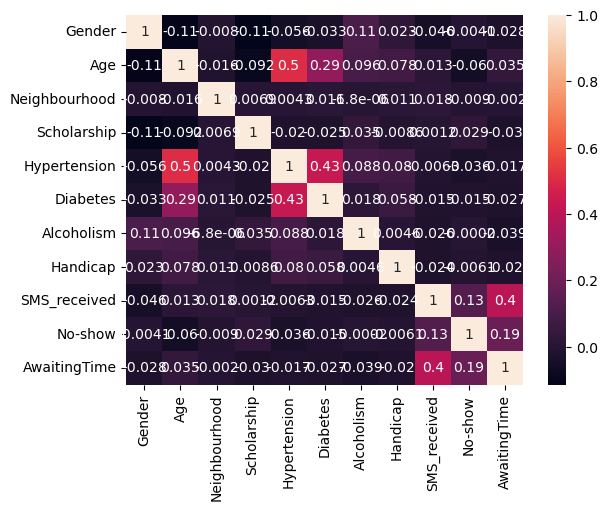

In [25]:
# Visualize the correlation matrix as a heatmap
sns.heatmap(corr_matrix, annot=True)

# Identify highly correlated features
highly_correlated = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            colname = corr_matrix.columns[i]
            highly_correlated.add(colname)


In [26]:
# Drop highly correlated features
data = data.drop(columns=highly_correlated)

# B. Model Development : Naïve Bayes classifier

In [27]:
# Select relevant features for the classifier
features = ['Gender', 'Age', 'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handicap', 
            'SMS_received', 'AwaitingTime']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data[features], data['No-show'], test_size=0.3, random_state=1)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

# Initialize the classifier
nb = GaussianNB()

# Train the classifier
nb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


(77366, 9) (77366,)
(33157, 9) (33157,)
Accuracy: 0.7696112434779986


Classification Report is:
               precision    recall  f1-score   support

           0       0.81      0.93      0.87     26477
           1       0.33      0.14      0.20      6680

    accuracy                           0.77     33157
   macro avg       0.57      0.53      0.53     33157
weighted avg       0.71      0.77      0.73     33157


 F1:
 0.19716237519705726

 Precision score is:
 0.3308641975308642

 Recall score is:
 0.1404191616766467

 Confusion Matrix:



<AxesSubplot: >

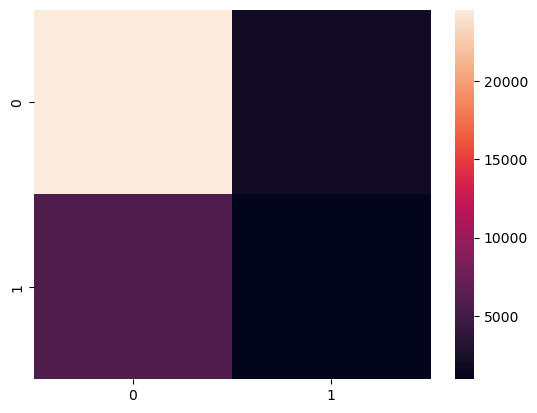

In [28]:
print("Classification Report is:\n",classification_report(y_test, y_pred))
print("\n F1:\n",f1_score(y_test, y_pred))
print("\n Precision score is:\n",precision_score(y_test, y_pred))
print("\n Recall score is:\n",recall_score(y_test, y_pred))
print("\n Confusion Matrix:\n")
sns.heatmap(confusion_matrix(y_test, y_pred))

# C. Model Evaluation & Comparison

## 1. Write a Function to detect the model’s Accuracy by applying the trained model on a testing dataset to find the predicted labels of Status. Was there overfitting?

In [29]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Predict the test set labels
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Predict the training set labels
    y_train_pred = model.predict(X_train)

    # Calculate training set accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Check for overfitting
    overfitting = train_accuracy - accuracy

    # Print the results
    print("Accuracy on test set:", accuracy)
    print("Accuracy on training set:", train_accuracy)
    print("Overfitting:", overfitting)

## 2. Tune the model using GridSearchCV

In [30]:
# Set the range of hyperparameters
param_grid_nb = {
    'var_smoothing': np.logspace(0,-2, num=100)
}

# Create the GridSearchCV object
nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)

# Fit the GridSearchCV object to the training data
nbModel_grid.fit(X_train, y_train)

# Get the best hyperparameters
best_params = nbModel_grid.best_params_
print('Best Parameters:', best_params)

# Get the best model
best_gnb = nbModel_grid.best_estimator_


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best Parameters: {'var_smoothing': 1.0}


## 3. Using the same data set partitioning method, evaluate the performance of a SVM and Decision tree classifier on the dataset. Compare the results of the Naïve Bayes classifier with SVM and Decision tree model according to the following criteria: Accuracy, Sensitivity, Specificity & F1 score. Identify the model that performed best and worst according to each criterion.

In [31]:
# SVM
svm = SVC()
# svm = SVC(C=1.0, kernel='linear', gamma='auto')
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
svm_report = classification_report(y_test, svm_pred)
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_precision = precision_score(y_test, svm_pred)
svm_recall = recall_score(y_test, svm_pred)
svm_f1_score = f1_score(y_test, svm_pred)

# Decision tree
dt = DecisionTreeClassifier(random_state=42)
# dt = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=42)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_report = classification_report(y_test, dt_pred)
dt_accuracy = accuracy_score(y_test, dt_pred)
dt_precision = precision_score(y_test, dt_pred)
dt_recall = recall_score(y_test, dt_pred)
dt_f1_score = f1_score(y_test, dt_pred)
dt_report = classification_report(y_test, dt_pred)

# Naive Bayes
nb_pred = best_gnb.predict(X_test)
nb_report = classification_report(y_test, nb_pred)
nb_accuracy = accuracy_score(y_test, nb_pred)
nb_precision = precision_score(y_test, nb_pred)
nb_recall = recall_score(y_test, nb_pred)
nb_f1_score = f1_score(y_test, nb_pred)


print('SVM Performance:\n', svm_report)
print("Accuracy:", svm_accuracy)
print("Sensitivity/Recall:", svm_recall)
print("Specificity:", svm_accuracy-svm_recall)
print("F1 Score:", svm_f1_score)

print('Decision Tree Performance:\n', dt_report)
print("Accuracy:", dt_accuracy)
print("Sensitivity/Recall:", dt_recall)
print("Specificity:", dt_accuracy-dt_recall)
print("F1 Score:", dt_f1_score)

print('Naive Bayes Performance:\n', nb_report)
print("Accuracy:", nb_accuracy)
print("Sensitivity/Recall:", nb_recall)
print("Specificity:", nb_accuracy-nb_recall)
print("F1 Score:", nb_f1_score)

SVM Performance:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89     26477
           1       0.00      0.00      0.00      6680

    accuracy                           0.80     33157
   macro avg       0.40      0.50      0.44     33157
weighted avg       0.64      0.80      0.71     33157

Accuracy: 0.798534246162198
Sensitivity/Recall: 0.0
Specificity: 0.798534246162198
F1 Score: 0.0
Decision Tree Performance:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86     26477
           1       0.34      0.19      0.25      6680

    accuracy                           0.76     33157
   macro avg       0.58      0.55      0.55     33157
weighted avg       0.72      0.76      0.74     33157

Accuracy: 0.7624332720089272
Sensitivity/Recall: 0.19266467065868265
Specificity: 0.5697686013502445
F1 Score: 0.24629222084011101
Naive Bayes Performance:
               precision    recall  f1-score   

## 4. Carry out a ROC analysis to compare the performance of the Naïve Bayes, SVM model with the Decision Tree model. Plot the ROC graph of the models. 

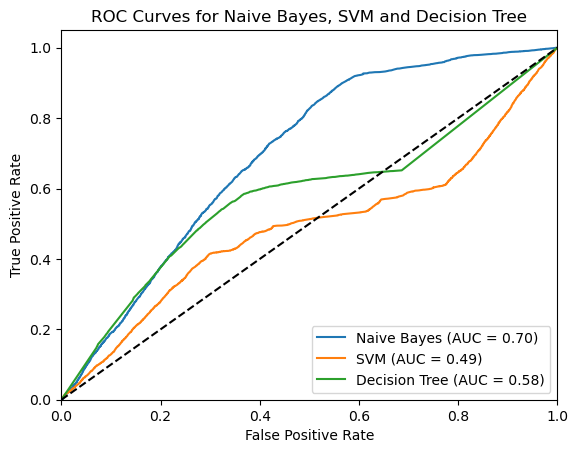

In [32]:
# Compute ROC and AUC for Naive Bayes
nb_pred_prob = best_gnb.predict_proba(X_test)[:, 1]
nb_fpr, nb_tpr, nb_thresholds = roc_curve(y_test, nb_pred_prob)
nb_auc = roc_auc_score(y_test, nb_pred_prob)

# Compute ROC and AUC for SVM
svm_pred_prob = svm.decision_function(X_test)
svm_fpr, svm_tpr, svm_thresholds = roc_curve(y_test, svm_pred_prob)
svm_auc = roc_auc_score(y_test, svm_pred_prob)

# Compute ROC and AUC for Decision Tree
dt_pred_prob = dt.predict_proba(X_test)[:, 1]
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, dt_pred_prob)
dt_auc = roc_auc_score(y_test, dt_pred_prob)

# Plot ROC curves for all classifiers
plt.plot(nb_fpr, nb_tpr, label='Naive Bayes (AUC = %0.2f)' % nb_auc)
plt.plot(svm_fpr, svm_tpr, label='SVM (AUC = %0.2f)' % svm_auc)
plt.plot(dt_fpr, dt_tpr, label='Decision Tree (AUC = %0.2f)' % dt_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Naive Bayes, SVM and Decision Tree')
plt.legend(loc="lower right")
plt.show()
